In [1]:
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("figs/", exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 48
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

## Load experiment results

In [2]:
config_table = pd.read_csv("results-bandwidth/setting-table.csv", index_col=0)
assert len(config_table) == 1728 + 1

mean_vals = pd.read_csv("results-bandwidth/mean_vals.csv")
OPTUNA_INDEX = config_table[config_table.alpha.isna()].index.tolist()
optuna_vals = mean_vals[np.any([mean_vals.setting_index == idx for idx in OPTUNA_INDEX], axis=0)]
mean_vals = mean_vals[np.all([mean_vals.setting_index != idx for idx in OPTUNA_INDEX], axis=0)]

target_names = mean_vals.target.unique()
target_cols = mean_vals.target
target_names

array(['Perm_10d', 'Schwefel_05d', 'Rosenbrock_10d', 'Rastrigin_30d',
       'KTablet_10d', 'Sphere_05d', 'Rosenbrock_30d',
       'WeightedSphere_10d', 'WeightedSphere_30d', 'cifar10',
       'Styblinski_10d', 'Ackley_30d', 'parkinsons_telemonitoring',
       'Levy_30d', 'XinSheYang_30d', 'Sphere_10d', 'Griewank_05d',
       'Ackley_10d', 'car', 'Levy_05d', 'Sphere_30d', 'segment',
       'Griewank_10d', 'naval_propulsion', 'KTablet_05d', 'phoneme',
       'Styblinski_30d', 'Rosenbrock_05d', 'Schwefel_30d', 'Perm_30d',
       'XinSheYang_05d', 'credit_g', 'XinSheYang_10d', 'fashion_mnist',
       'australian', 'Rastrigin_05d', 'blood_transfusion', 'Perm_05d',
       'Rastrigin_10d', 'WeightedSphere_05d', 'Ackley_05d', 'vehicle',
       'kc1', 'colorectal_histology', 'KTablet_30d', 'Griewank_30d',
       'Schwefel_10d', 'Levy_10d', 'Styblinski_05d', 'slice_localization',
       'protein_structure'], dtype=object)

## Preprocess results

In [3]:
optuna_mask = config_table.alpha.isna()
linear_mask = config_table["quantile"] == "linear"
sqrt_mask = config_table["quantile"] == "sqrt"

config = config_table[~optuna_mask]

### Figures to create

Def: No. params is $D$, No. settings is $K$.

1. HPI for Bench5D, Bench10D, Bench30D, HPOBench, HPOlib, and JAHS-Bench (table)
2. Marginal distributions for each param for each setting ($5 \times D \times K$ subfigures)
3. The HPI ranking distribution at 50,100,150,200 for each ($5 \times D \times K$ subfigures)

In [4]:
from parzen_estimator import (
    CategoricalParzenEstimator,
    CategoricalUniform,
    NumericalParzenEstimator,
    NumericalUniform,
)

is_categoricals = {
    "min_bandwidth_factor": False,
    "magic-clip-exponent": True,
    "heuristic": True,
    "quantile": True,
    "alpha": False,
    "weight": True,
}


def get_pdf(
    X_top: np.ndarray,
    n_choices: int,
    is_categorical: bool,
):
    if is_categorical:
        pdf = CategoricalParzenEstimator(
            samples=X_top, top=1.0, n_choices=n_choices, prior=False,
        )
    else:
        pdf = NumericalParzenEstimator(
            samples=X_top,
            lb=0,
            ub=n_choices - 1,
            q=1,
            compress=True,
            dtype=int,
            prior=False,
        ) if X_top.size > 0 else NumericalUniform(lb=0, ub=n_choices - 1)
    return pdf


def build_pdf(
    param_name: str,
    X: pd.DataFrame,
    F: np.ndarray,
    order: np.ndarray,
    top_quantile: float,
):
    top_mask = F <= F[order[int(top_quantile * F.size)]]
    if param_name == "alpha":
        linear_mask = X["quantile"] == "linear"
        x = X[param_name]

        codes, unique_vals = x[linear_mask].factorize(sort=True)
        n_choices = unique_vals.size
        pdf_linear = get_pdf(codes[top_mask[linear_mask]], n_choices, is_categorical=False)

        codes, unique_vals = x[~linear_mask].factorize(sort=True)
        n_choices = unique_vals.size
        pdf_sqrt = get_pdf(codes[top_mask[~linear_mask]], n_choices, is_categorical=False)
        return pdf_linear, pdf_sqrt

    codes, unique_vals = X[param_name].factorize(sort=True)    
    n_choices = unique_vals.size
    is_categorical = is_categoricals[param_name]
    return get_pdf(codes[top_mask], n_choices, is_categorical)


def collect_pdfs(
    target_name: str,
    target_config: pd.DataFrame,
    top_quantile: float,
):
    pdf_dict = dict()
    target_epochs = np.asarray([50, 100, 150, 200]) - 1
    target_mean = mean_vals[target_cols == target_name]

    F_dict = {e: [] for e in target_epochs}
    for idx in target_config.index:
        m = target_mean[target_mean.setting_index == idx].iloc[0].to_numpy()[2:].astype(np.float32)
        for e in target_epochs:
            F_dict[e].append(m[e])
    else:
        F_dict = {e: np.asarray(F) for e, F in F_dict.items()}

    for e in target_epochs:
        F = F_dict[e]
        order = np.argsort(F)
        for param_name in target_config.columns:
            # key: "param_name:n_evals:top-quantile"
            if param_name == "alpha":
                pdf_linear, pdf_sqrt = build_pdf(param_name, target_config, F, order, top_quantile)
                key_linear = f"linear_{param_name}:{e+1:0>3}:{int(top_quantile * 100):0>2}"
                key_sqrt = f"sqrt_{param_name}:{e+1:0>3}:{int(top_quantile * 100):0>2}"
                pdf_dict[key_linear], pdf_dict[key_sqrt] = pdf_linear, pdf_sqrt
            else:
                pdf = build_pdf(param_name, target_config, F, order, top_quantile)
                key = f"{param_name}:{e+1:0>3}:{int(top_quantile * 100):0>2}"
                pdf_dict[key] = pdf

    return pdf_dict

## Build all required density estimators

In [11]:
PC1, PC2 = 50, 5

pdf_dict = dict()
for target_name in target_names:
    pdf_dict[target_name] = {}
    pdf_dict[target_name].update(collect_pdfs(target_name, config, top_quantile=PC1/100))
    pdf_dict[target_name].update(collect_pdfs(target_name, config, top_quantile=PC2/100))

In [12]:
unique_val_dict = {}
for col in config.columns:
    if col != "alpha":
        unique_val_dict[col] = list(config[col].factorize(sort=True)[1])
    else:
        linear_mask = config["quantile"] == "linear"
        unique_val_dict[f"linear_{col}"] = list(config[linear_mask][col].factorize(sort=True)[1])
        unique_val_dict[f"sqrt_{col}"] = list(config[~linear_mask][col].factorize(sort=True)[1])

unique_val_dict = {k: [str(v) for v in uvs] for k, uvs in unique_val_dict.items()}
unique_val_dict["weight"] = [
    {"expected-improvement": "EI", "uniform": "Uniform", "older-smaller": "Old decay"}[s]
    for s in unique_val_dict["weight"]
]
unique_val_dict["quantile"] = [{"linear": "Linear", "sqrt": "Sqrt"}[s] for s in unique_val_dict["quantile"]]
unique_val_dict["heuristic"] = [
    {"hyperopt": "Hyperopt", "scott": "Scott", "optuna": "Optuna"}[s]
    for s in unique_val_dict["heuristic"]
]
unique_val_dict["magic-clip-exponent"][-1] = "$\\infty$"

param_name_dict = {
    "heuristic": "Bandwidth heuristic",
    "min_bandwidth_factor": "$\\Delta$ (factor of $b_{\min}$)",
    "magic-clip-exponent": "Exponent for $b_{\mathrm{magic}}$",
    "quantile": "Splitting algorithm",
    "linear_alpha": "$\\beta_1$ (linear)",
    "sqrt_alpha": "$\\beta_2$ (sqrt)",
    "weight": "Weighting algorithm",
}


def plot_pdf(bench_names, bbox_to_anchor):
    global_hpi_df, local_hpi_df = [], []
    for r, n_evals in enumerate([50, 100, 150, 200]):
        param_names = list(set([k.split(":")[0] for k in pdf_dict[bench_names[0]].keys()]))
        global_hpi, local_hpi = {}, {}
        lines = []

        for c, (param_name, title) in enumerate(param_name_dict.items()):
            ax = axes[r][c]
            unique_vals = unique_val_dict[param_name]
            dx = np.arange(len(unique_vals))

            global_hpi[param_name], local_hpi[param_name] = 0.0, 0.0
            avg_pdf_global, avg_pdf_local = np.zeros(len(unique_vals)), np.zeros(len(unique_vals))
            for target_name in bench_names:
                pdf_global = pdf_dict[target_name][f"{param_name}:{n_evals:0>3}:{PC1:0>2}"]
                pdf_local = pdf_dict[target_name][f"{param_name}:{n_evals:0>3}:{PC2:0>2}"]
                dx = np.arange(len(unique_vals))
                pg, pl = pdf_global(dx), pdf_local(dx)
                avg_pdf_global += pg
                avg_pdf_local += pl
                local_hpi[param_name] += pg @ ((pl / np.maximum(1e-12, pg) - 1) ** 2)
                global_hpi[param_name] += np.mean((dx.size * pg - 1) ** 2)
            else:
                local_hpi[param_name] /= len(bench_names)
                global_hpi[param_name] /= len(bench_names)
                avg_pdf_local /= len(bench_names)
                avg_pdf_global /= len(bench_names)

            buf = 0.5
            line1 = ax.bar(unique_vals, avg_pdf_global, alpha=0.2, color="blue")
            line2 = ax.bar(unique_vals, avg_pdf_local, alpha=0.2, color="red")
            line3 = ax.hlines(1 / dx.size, -buf, dx.size - 1 + buf, color="black", linestyle="--")
            ax.set_xlim(-buf, dx.size - 1 + buf)
            ax.set_ylim(0, 1)
            ax.grid()
            if r == 0:
                ax.set_title(title, fontsize=48)
            if c == 0:
                ax.set_ylabel(f"{n_evals} evaluations")
            if r != 3:
                ax.tick_params(labelbottom=False, bottom=False)
            elif param_name in ["weight", "heuristic"]:
                ax.tick_params(axis="x", labelrotation=30)

            if len(lines) == 0:
                lines = [line1, line2, line3]
        else:
            sg, sl = sum(global_hpi.values()), sum(local_hpi.values())
            label_dict = param_name_dict.copy()
            label_dict.update({
                "linear_alpha": "$\\beta_1$ (linear)",
                "sqrt_alpha": "$\\beta_2$ (Sqrt)",
            })
            global_hpi_df.append({label_dict[k]: f"{v * 100 / sg:.2f}\\%" for k, v in global_hpi.items()})
            local_hpi_df.append({label_dict[k]: f"{v * 100 / sl:.2f}\\%" for k, v in local_hpi.items()})

    labels = [f"Top-{PC1}% probability mass", f"Top-{PC2}% probability mass", "Uniform"]
    axes[-1][len(axes[0]) // 2].legend(
        handles=lines,
        loc='upper center',
        labels=labels,
        fontsize=48,
        bbox_to_anchor=bbox_to_anchor,  # ここは調整が必要です
        fancybox=False,
        ncol=len(labels)
    )
    fig.supylabel("Probability mass", x=0.085, fontsize=48)
    print(pd.DataFrame(global_hpi_df).T.style.to_latex())
    print(pd.DataFrame(local_hpi_df).T.style.to_latex())

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 0.95\% & 1.02\% & 1.31\% & 1.54\% \\
$\Delta$ (factor of $b_{\min}$) & 7.27\% & 11.43\% & 17.73\% & 21.60\% \\
Exponent for $b_{\mathrm{magic}}$ & 67.05\% & 66.02\% & 59.48\% & 58.83\% \\
Splitting algorithm & 0.78\% & 1.48\% & 2.26\% & 2.68\% \\
$\beta_1$ (linear) & 9.21\% & 5.93\% & 3.55\% & 2.56\% \\
$\beta_2$ (Sqrt) & 13.94\% & 13.22\% & 15.18\% & 12.45\% \\
Weighting algorithm & 0.81\% & 0.90\% & 0.47\% & 0.34\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 32.15\% & 33.50\% & 30.52\% & 29.79\% \\
$\Delta$ (factor of $b_{\min}$) & 23.56\% & 31.34\% & 36.59\% & 39.45\% \\
Exponent for $b_{\mathrm{magic}}$ & 13.83\% & 10.76\% & 10.37\% & 10.99\% \\
Splitting algorithm & 0.56\% & 0.38\% & 0.71\% & 1.63\% \\
$\beta_1$ (linear) & 5.83\% & 5.41\% & 3.25\% & 2.75\% \\
$\beta_2$ (Sqrt) & 11.57\% & 8.09\% & 7.44\% & 6.89\% \\
Weighting algorithm & 12.49\% & 10.50\% & 11.13\% & 8.50\% \\
\e

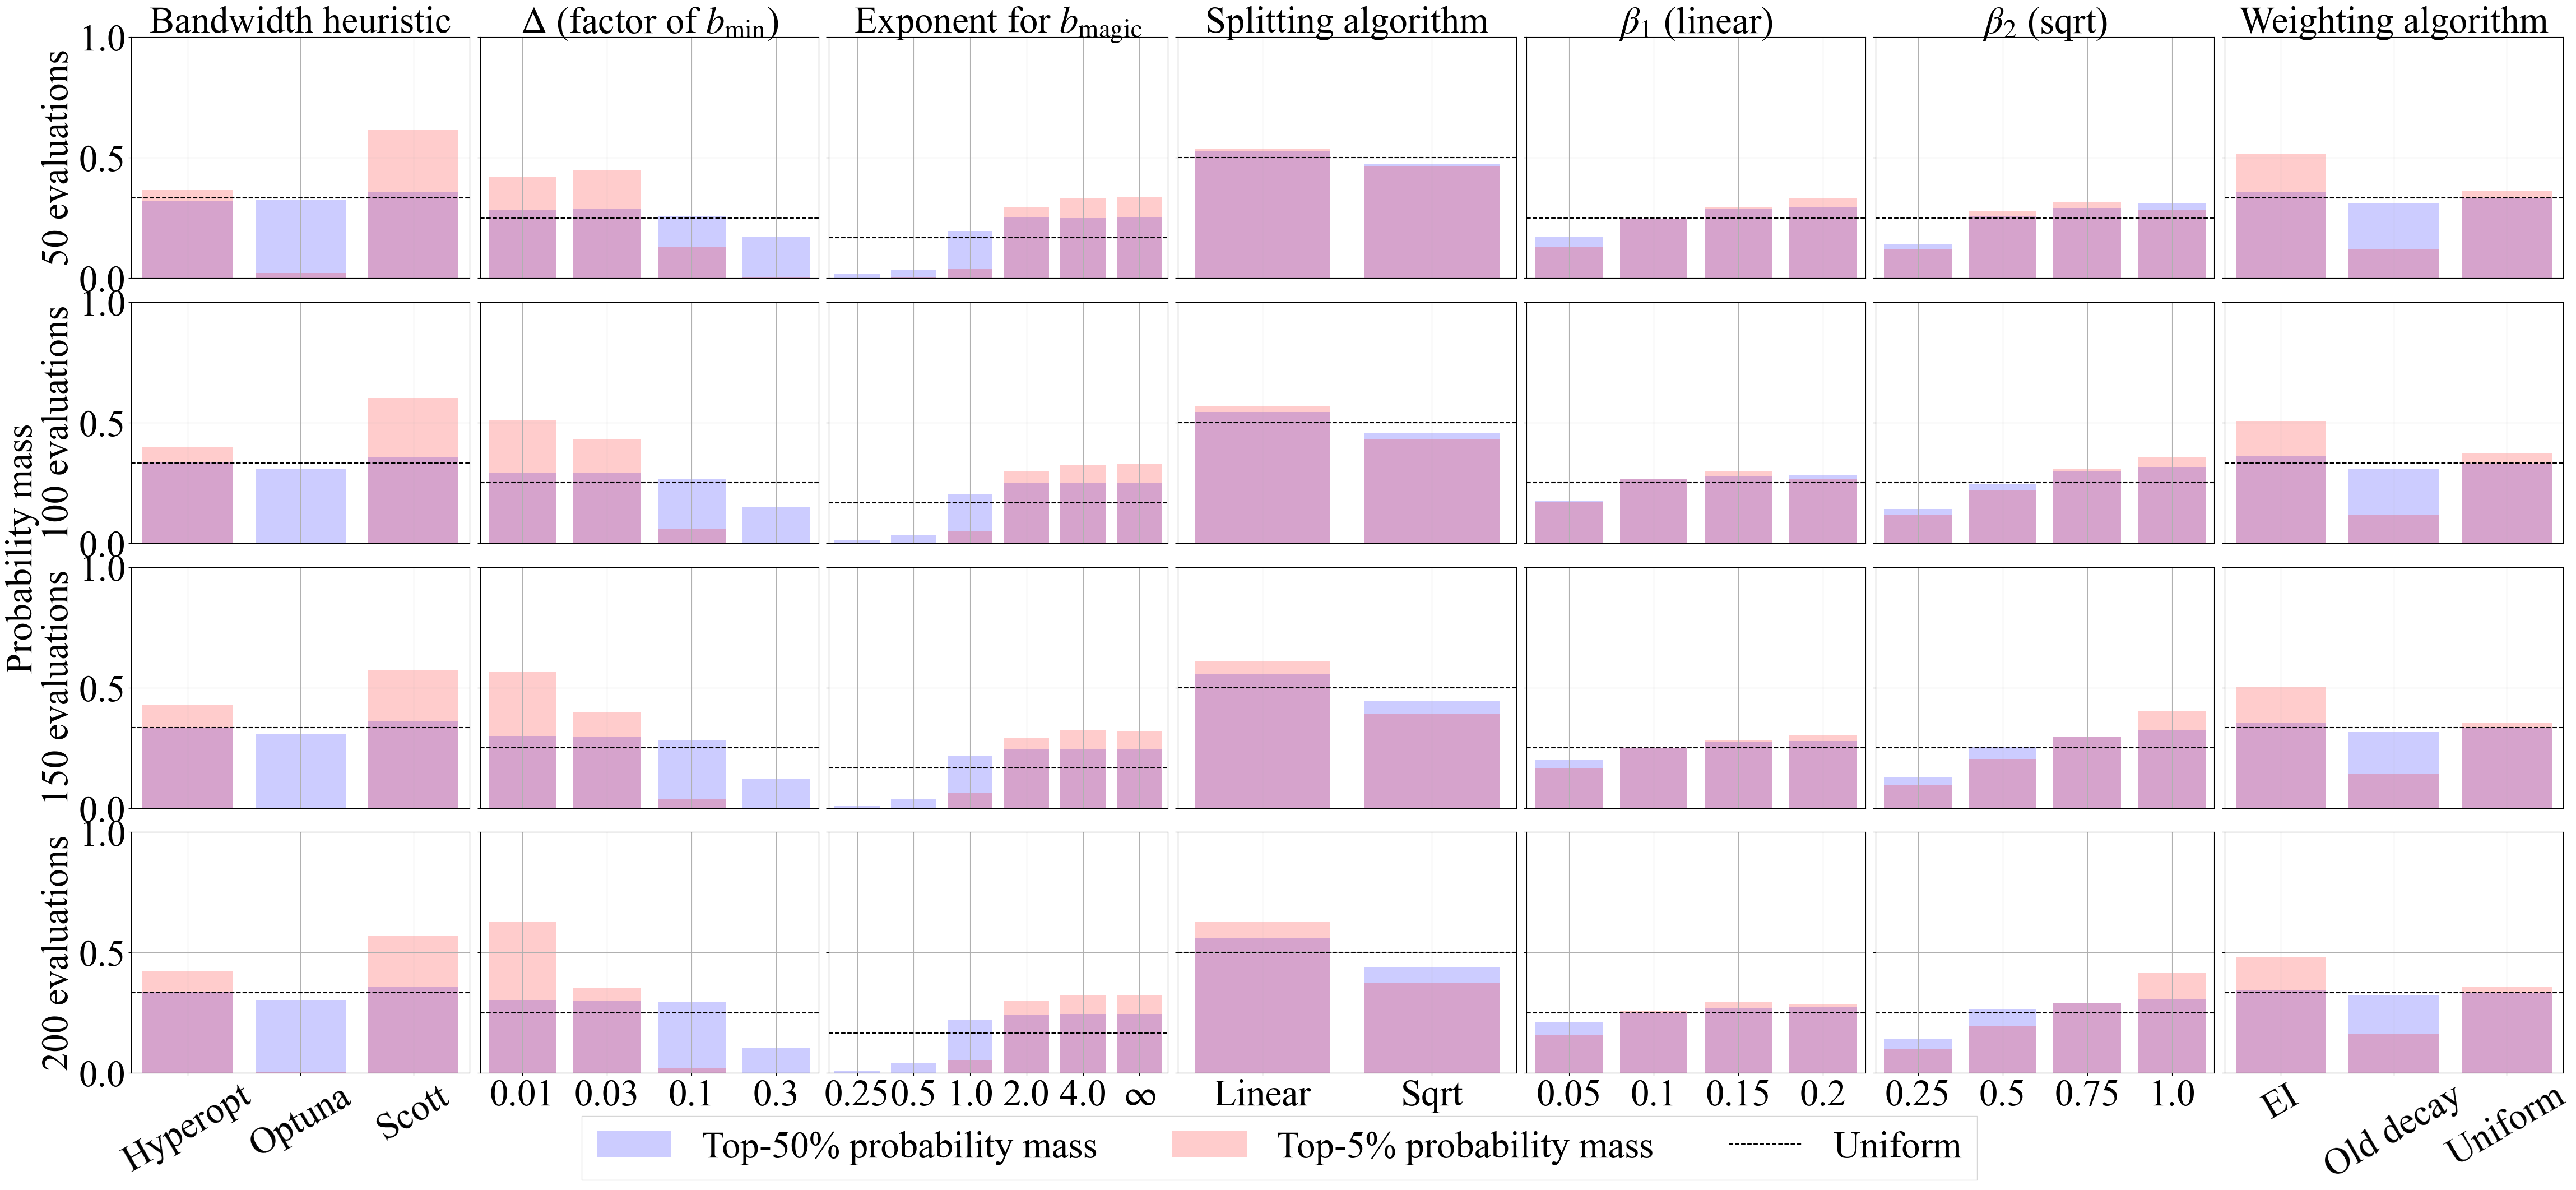

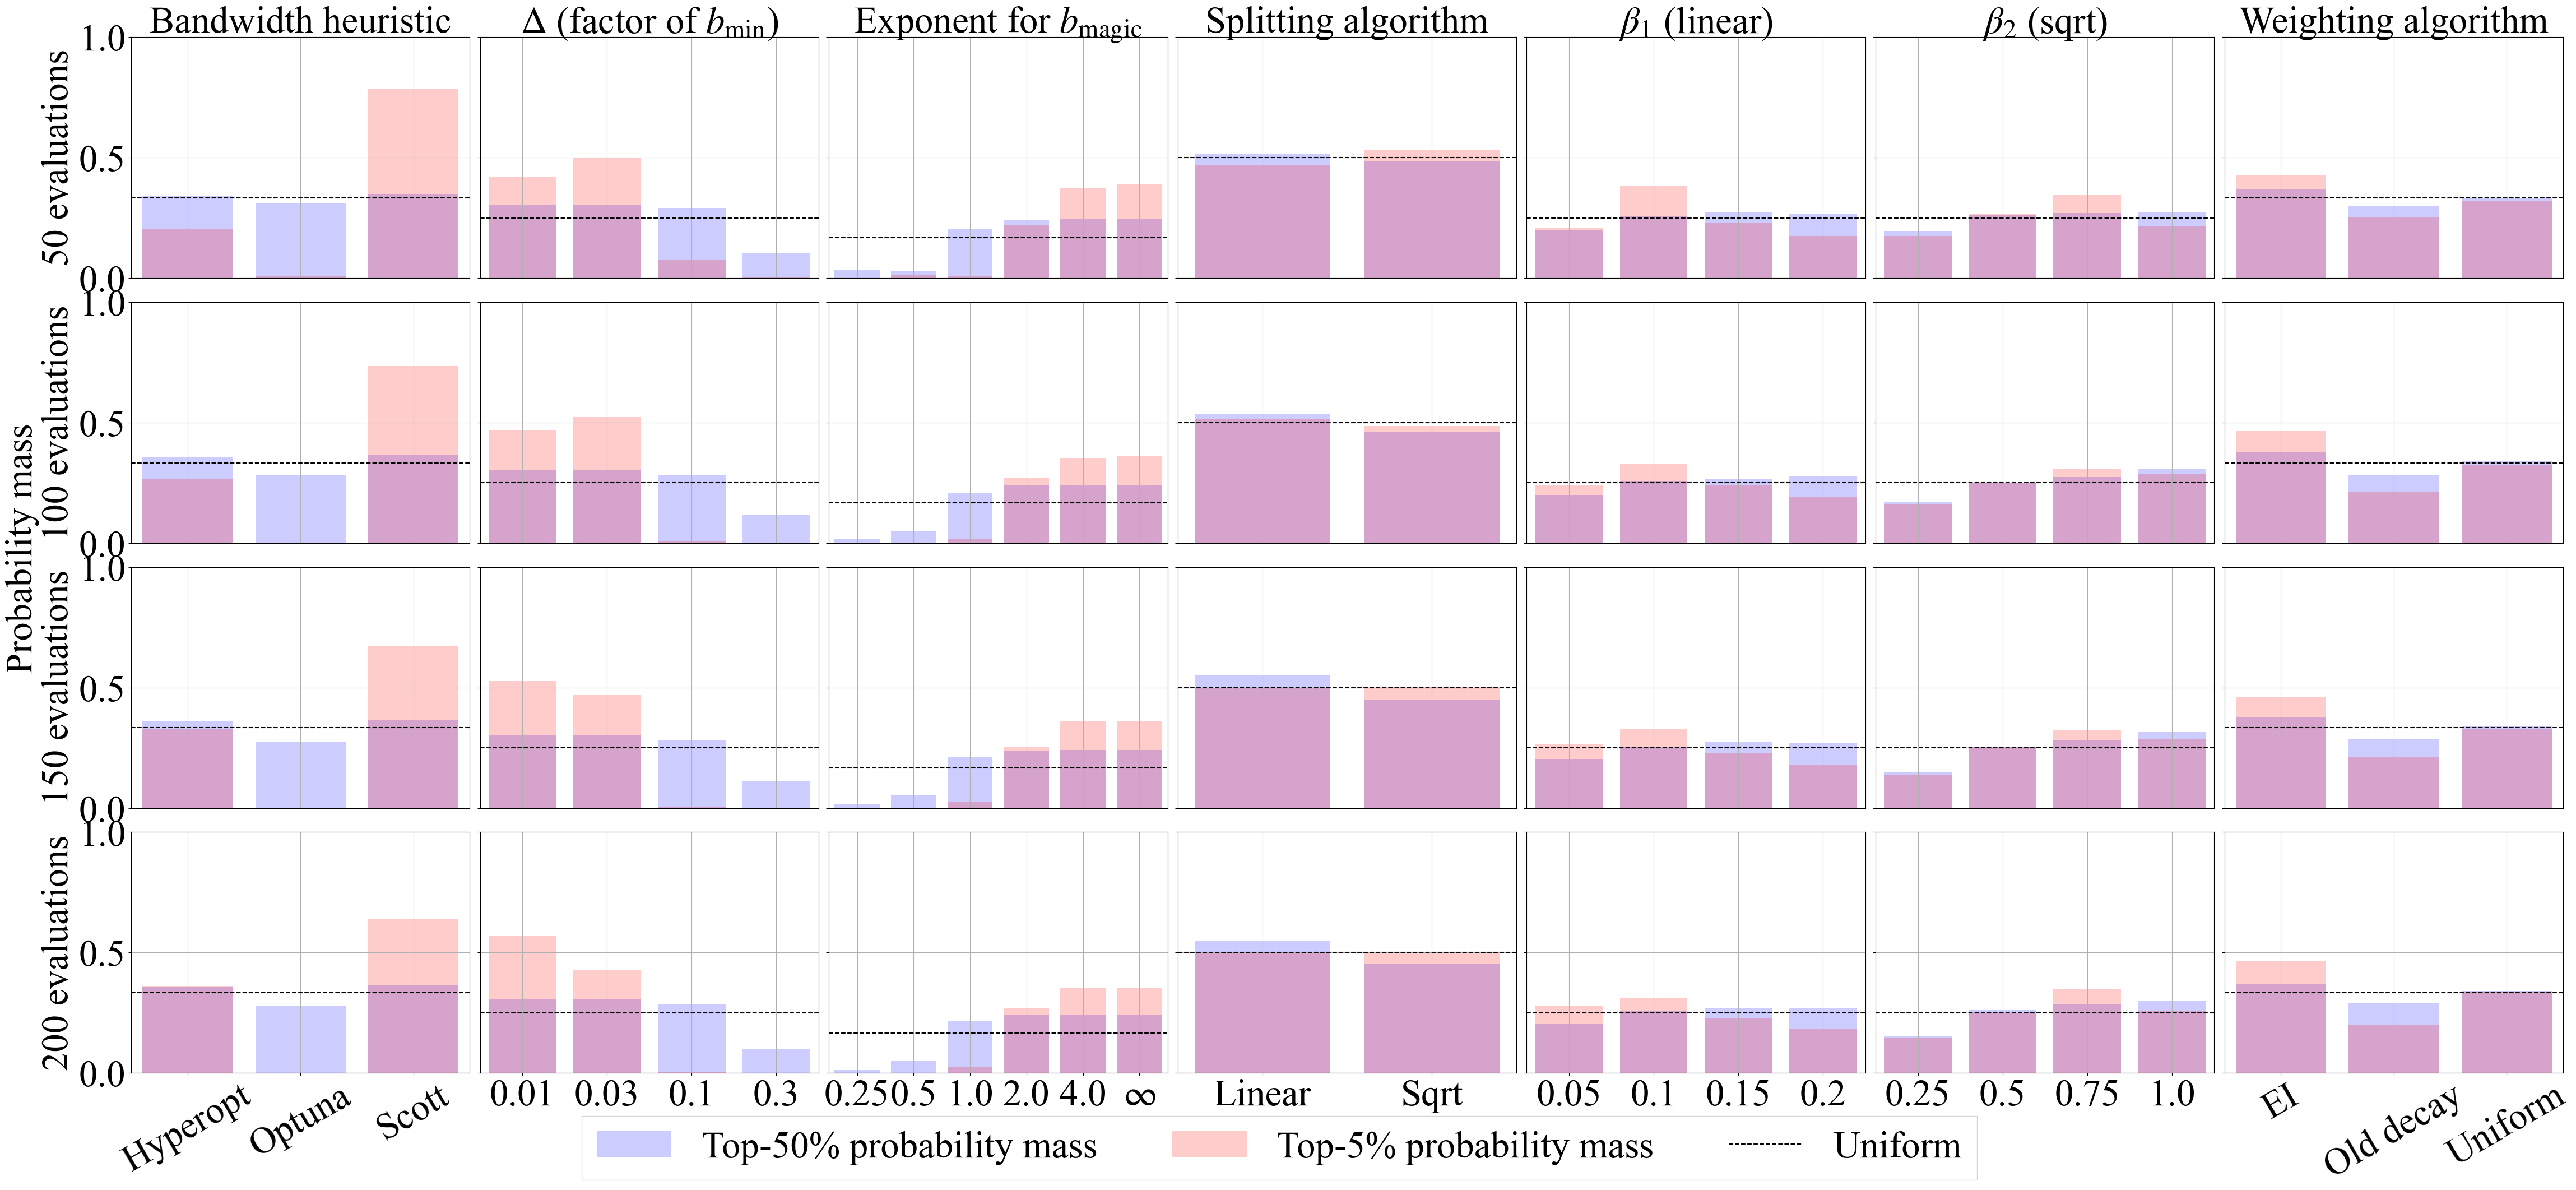

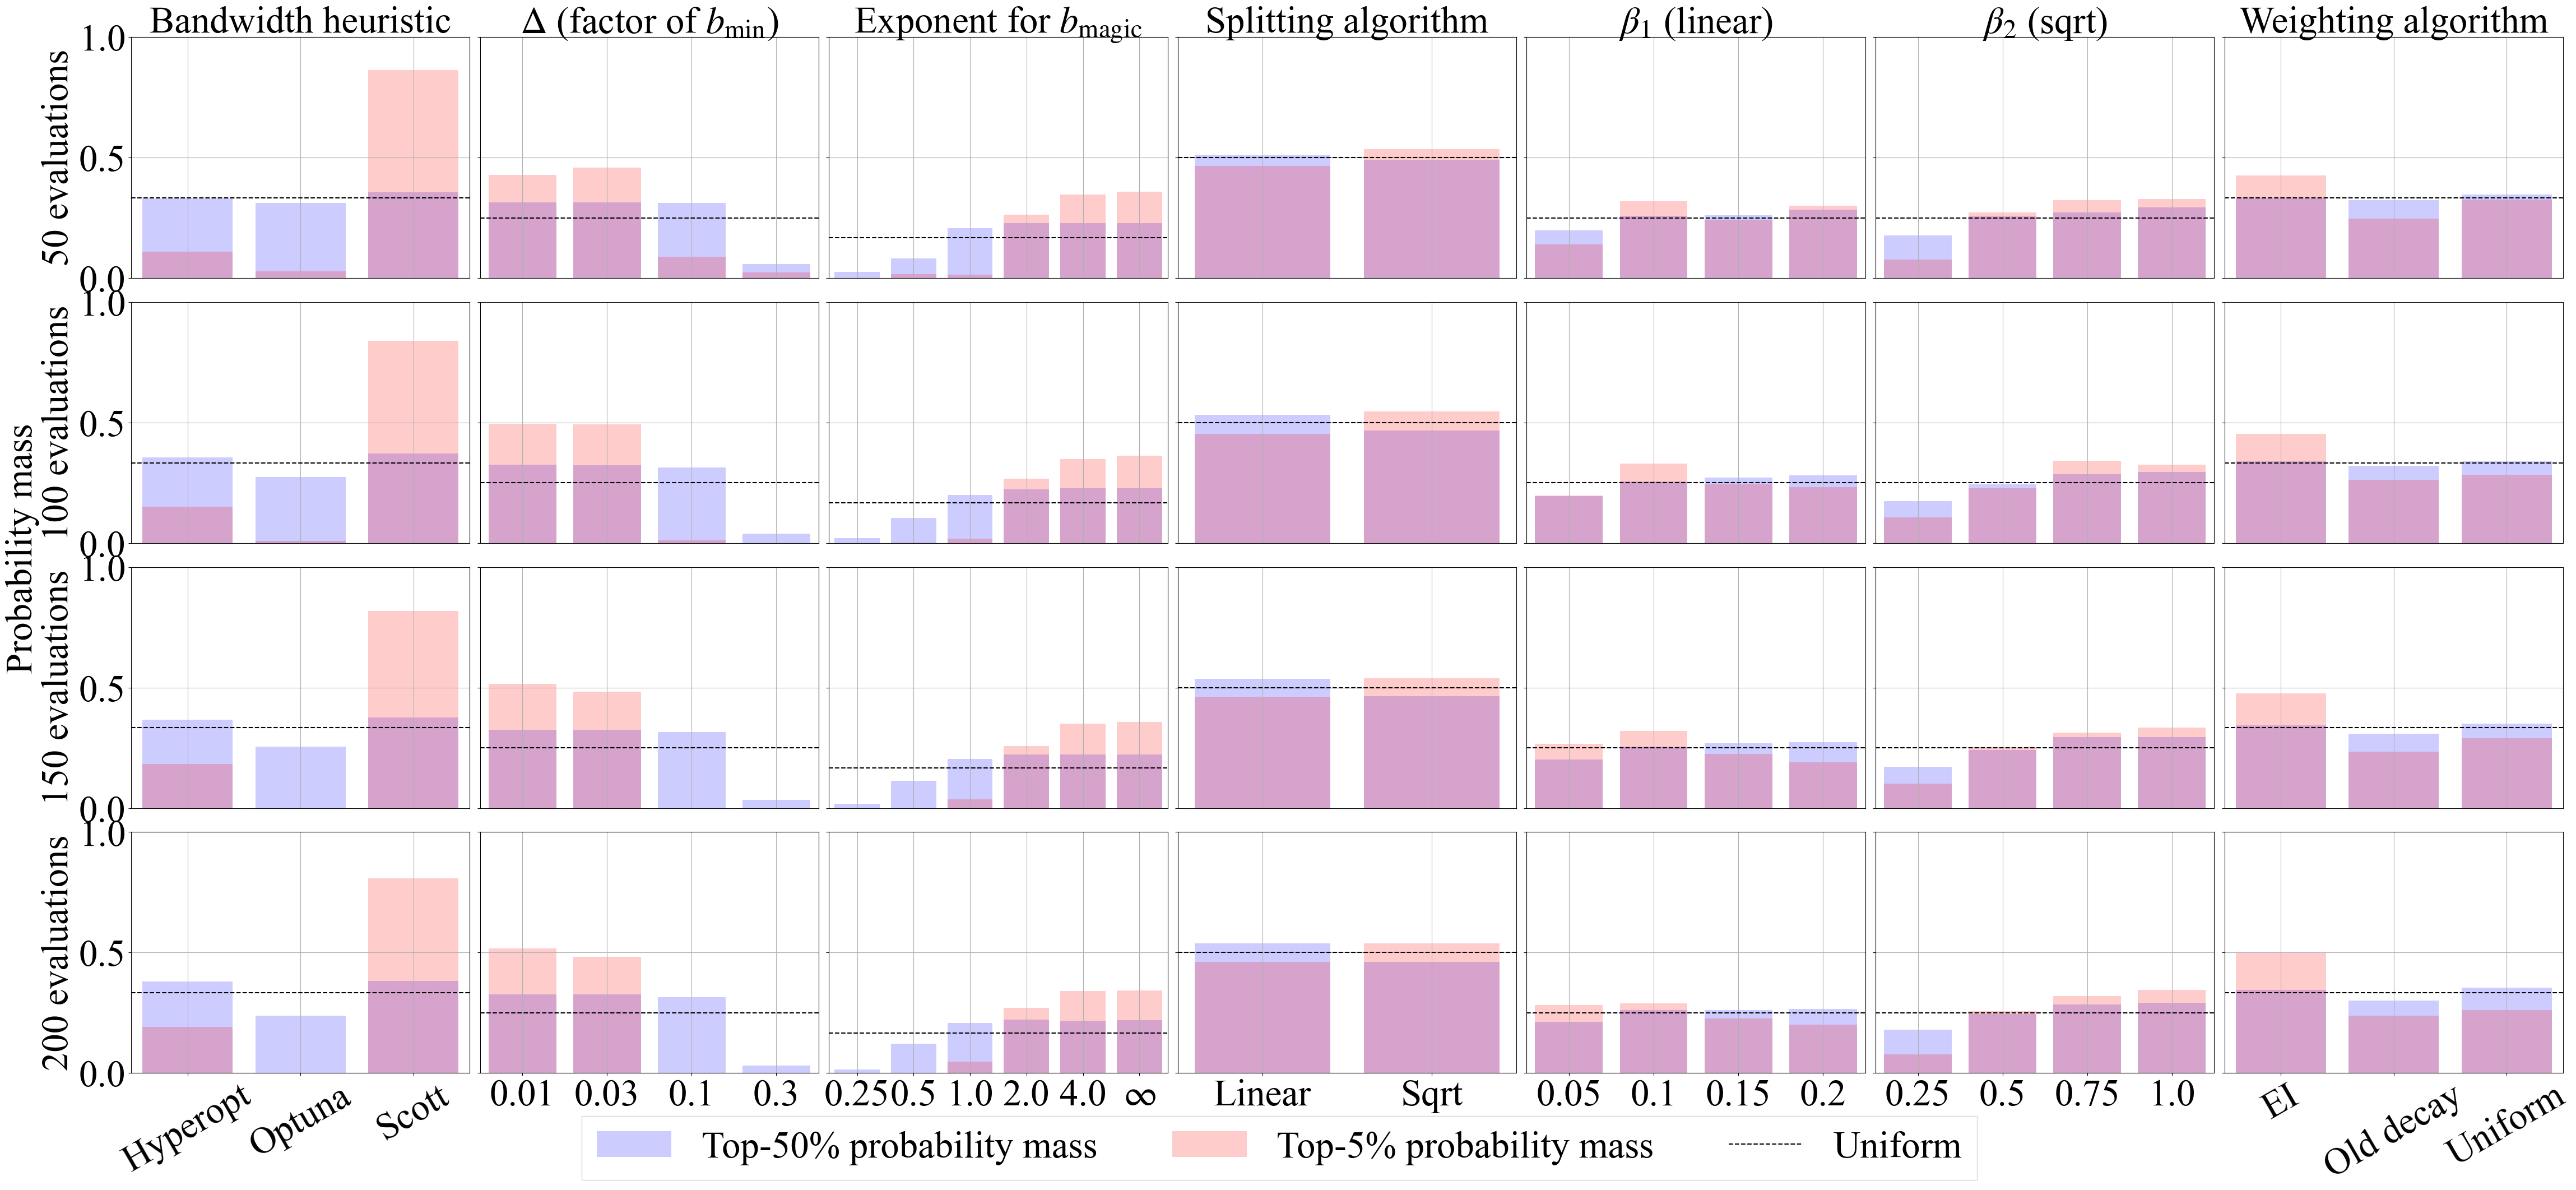

In [13]:
for suffix in ["_05d", "_10d", "_30d"]:
    fig, axes = plt.subplots(
        nrows=4,
        ncols=7,
        figsize=(56, 24),
        sharey=True,
        gridspec_kw=dict(
            wspace=0.03,
            hspace=0.1,
        )
    )

    bench_names = [name for name in target_names if name.endswith(suffix)]
    plot_pdf(bench_names, bbox_to_anchor=(0.3, -0.1))
    plt.savefig(f"figs/bench{suffix}-anova-bw.pdf", bbox_inches="tight")

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 1.35\% & 2.05\% & 2.94\% & 5.05\% \\
$\Delta$ (factor of $b_{\min}$) & 4.16\% & 7.25\% & 7.29\% & 8.28\% \\
Exponent for $b_{\mathrm{magic}}$ & 36.61\% & 45.66\% & 48.82\% & 50.08\% \\
Splitting algorithm & 1.98\% & 4.10\% & 6.01\% & 5.14\% \\
$\beta_1$ (linear) & 28.42\% & 14.35\% & 9.49\% & 7.49\% \\
$\beta_2$ (Sqrt) & 26.51\% & 25.72\% & 25.00\% & 23.51\% \\
Weighting algorithm & 0.97\% & 0.87\% & 0.45\% & 0.45\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 7.00\% & 7.67\% & 5.98\% & 6.42\% \\
$\Delta$ (factor of $b_{\min}$) & 8.54\% & 8.82\% & 7.57\% & 8.07\% \\
Exponent for $b_{\mathrm{magic}}$ & 21.51\% & 22.88\% & 23.75\% & 25.10\% \\
Splitting algorithm & 4.60\% & 7.42\% & 3.99\% & 1.39\% \\
$\beta_1$ (linear) & 14.47\% & 19.82\% & 17.06\% & 18.82\% \\
$\beta_2$ (Sqrt) & 33.87\% & 25.85\% & 33.13\% & 26.16\% \\
Weighting algorithm & 10.01\% & 7.55\% & 8.53\% & 14.04\% \\
\end{

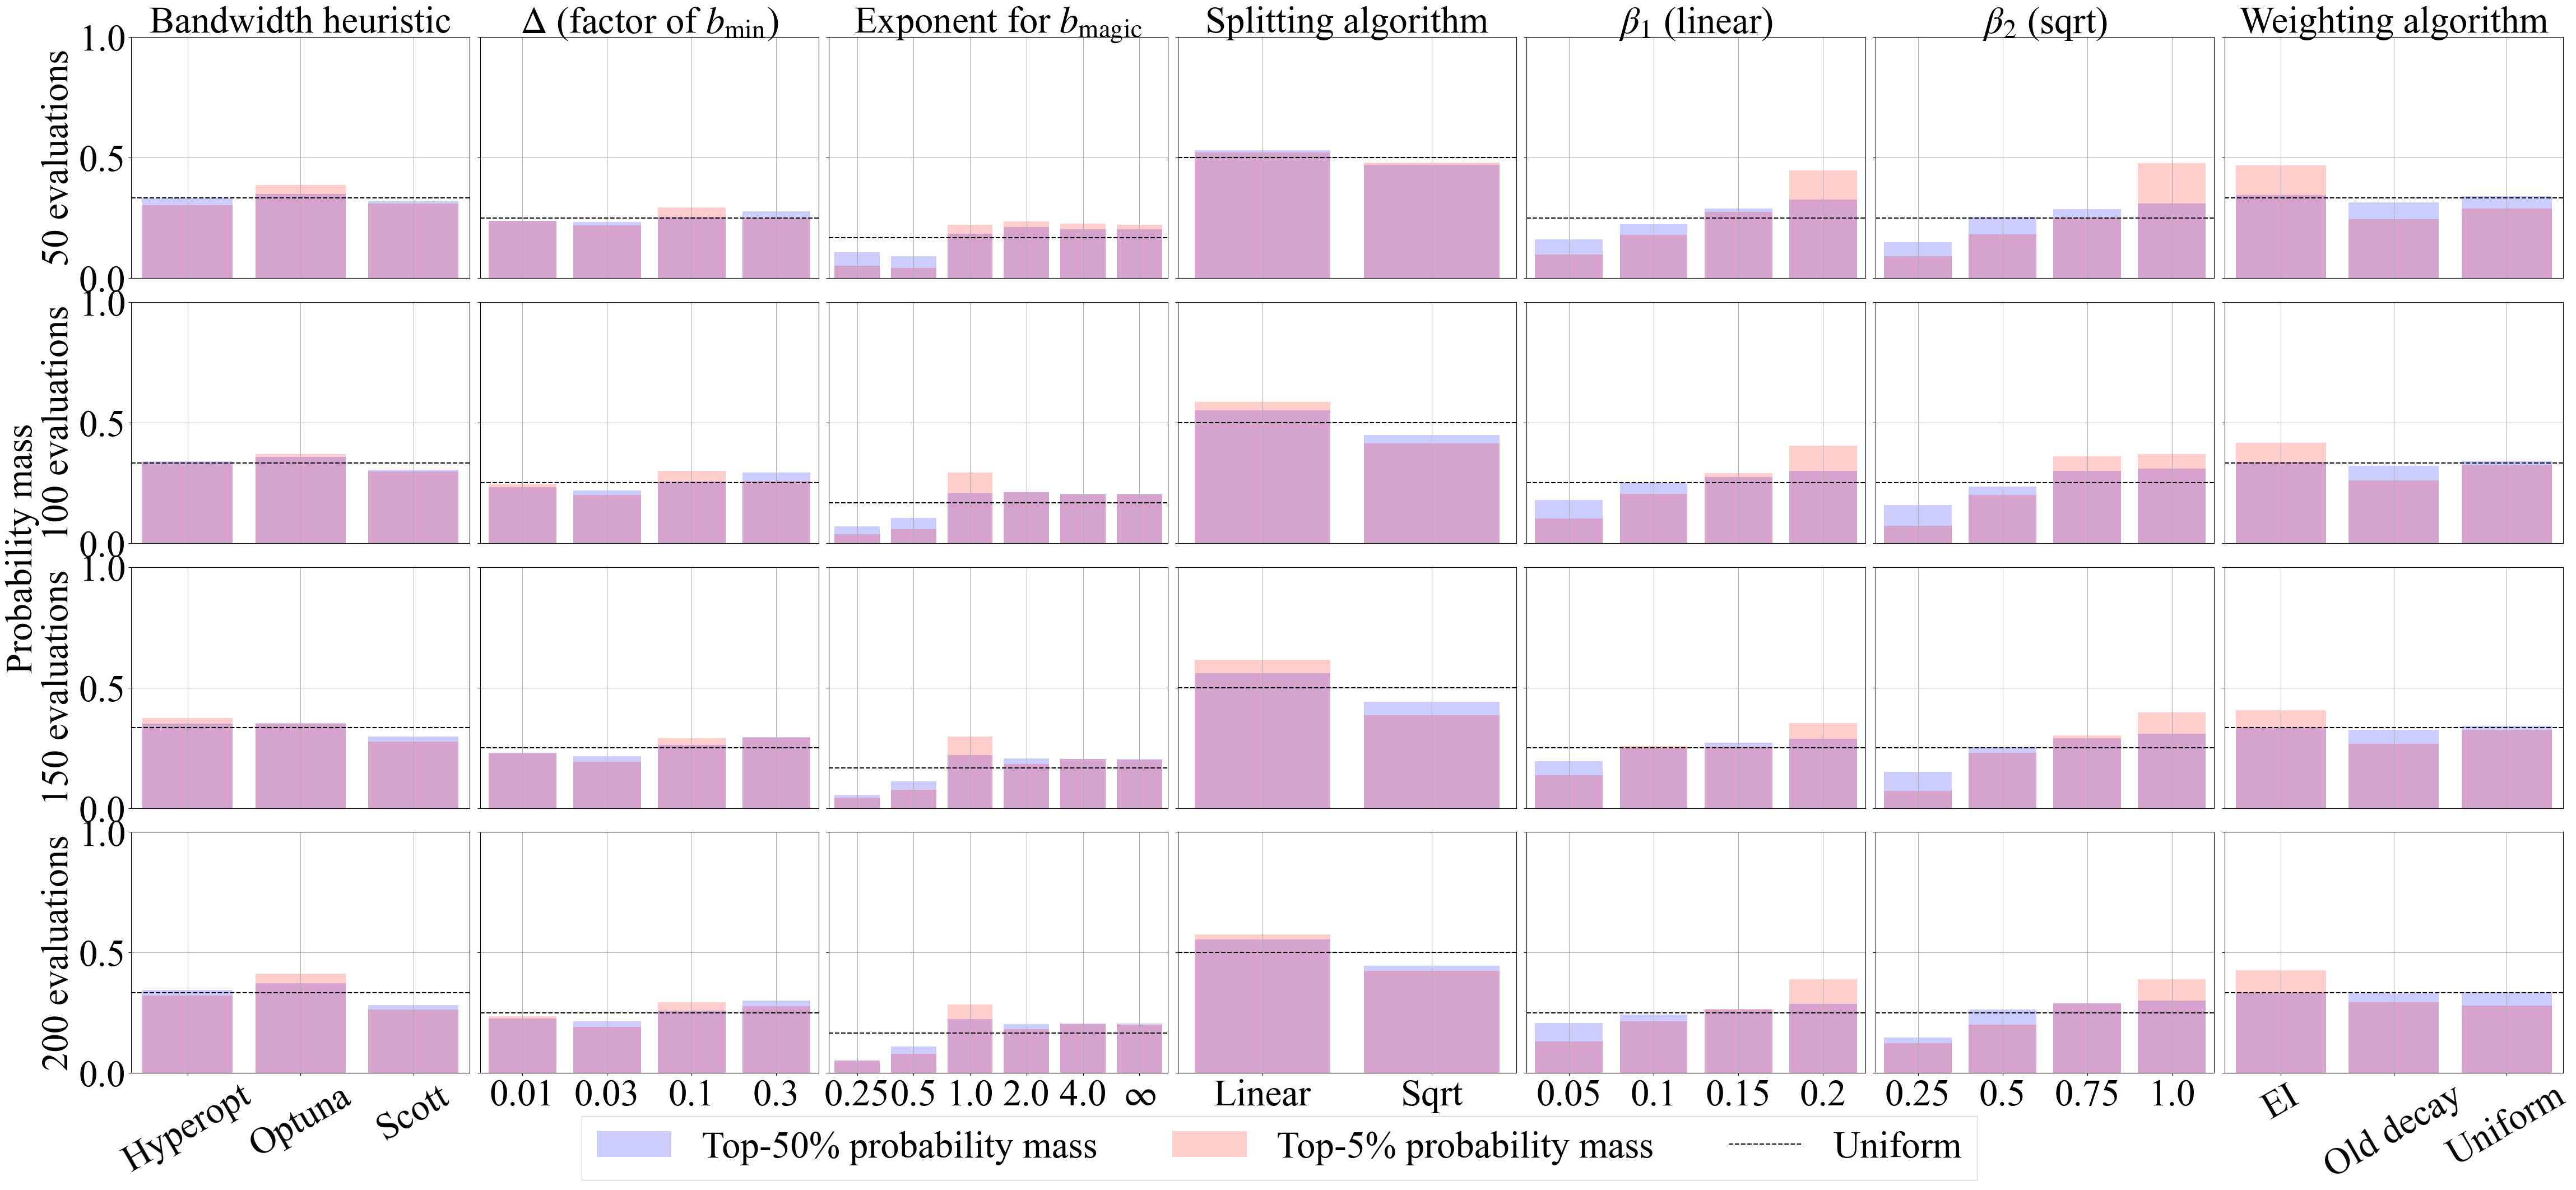

In [14]:
bench_names = [
    "vehicle",
    "segment",
    "car",
    "australian",
    "credit_g",
    "blood_transfusion",
    "kc1",
    "phoneme",
]

fig, axes = plt.subplots(
    nrows=4,
    ncols=7,
    figsize=(56, 24),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.03,
        hspace=0.1,
    )
)

plot_pdf(bench_names, bbox_to_anchor=(0.3, -0.1))
plt.savefig(f"figs/hpobench-anova-bw.pdf", bbox_inches="tight")

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 9.53\% & 5.83\% & 7.09\% & 9.83\% \\
$\Delta$ (factor of $b_{\min}$) & 8.56\% & 5.52\% & 5.51\% & 6.27\% \\
Exponent for $b_{\mathrm{magic}}$ & 58.61\% & 73.31\% & 65.36\% & 62.96\% \\
Splitting algorithm & 2.24\% & 1.73\% & 3.44\% & 3.95\% \\
$\beta_1$ (linear) & 7.80\% & 3.10\% & 1.02\% & 1.17\% \\
$\beta_2$ (Sqrt) & 6.86\% & 8.68\% & 16.79\% & 15.37\% \\
Weighting algorithm & 6.39\% & 1.83\% & 0.78\% & 0.45\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 3.97\% & 13.15\% & 16.80\% & 27.77\% \\
$\Delta$ (factor of $b_{\min}$) & 17.98\% & 16.57\% & 13.77\% & 14.28\% \\
Exponent for $b_{\mathrm{magic}}$ & 8.98\% & 5.68\% & 7.53\% & 8.18\% \\
Splitting algorithm & 0.29\% & 4.78\% & 10.45\% & 12.01\% \\
$\beta_1$ (linear) & 20.76\% & 13.24\% & 13.25\% & 12.28\% \\
$\beta_2$ (Sqrt) & 22.93\% & 37.13\% & 28.33\% & 18.11\% \\
Weighting algorithm & 25.10\% & 9.46\% & 9.86\% & 7.37\% \\
\end{

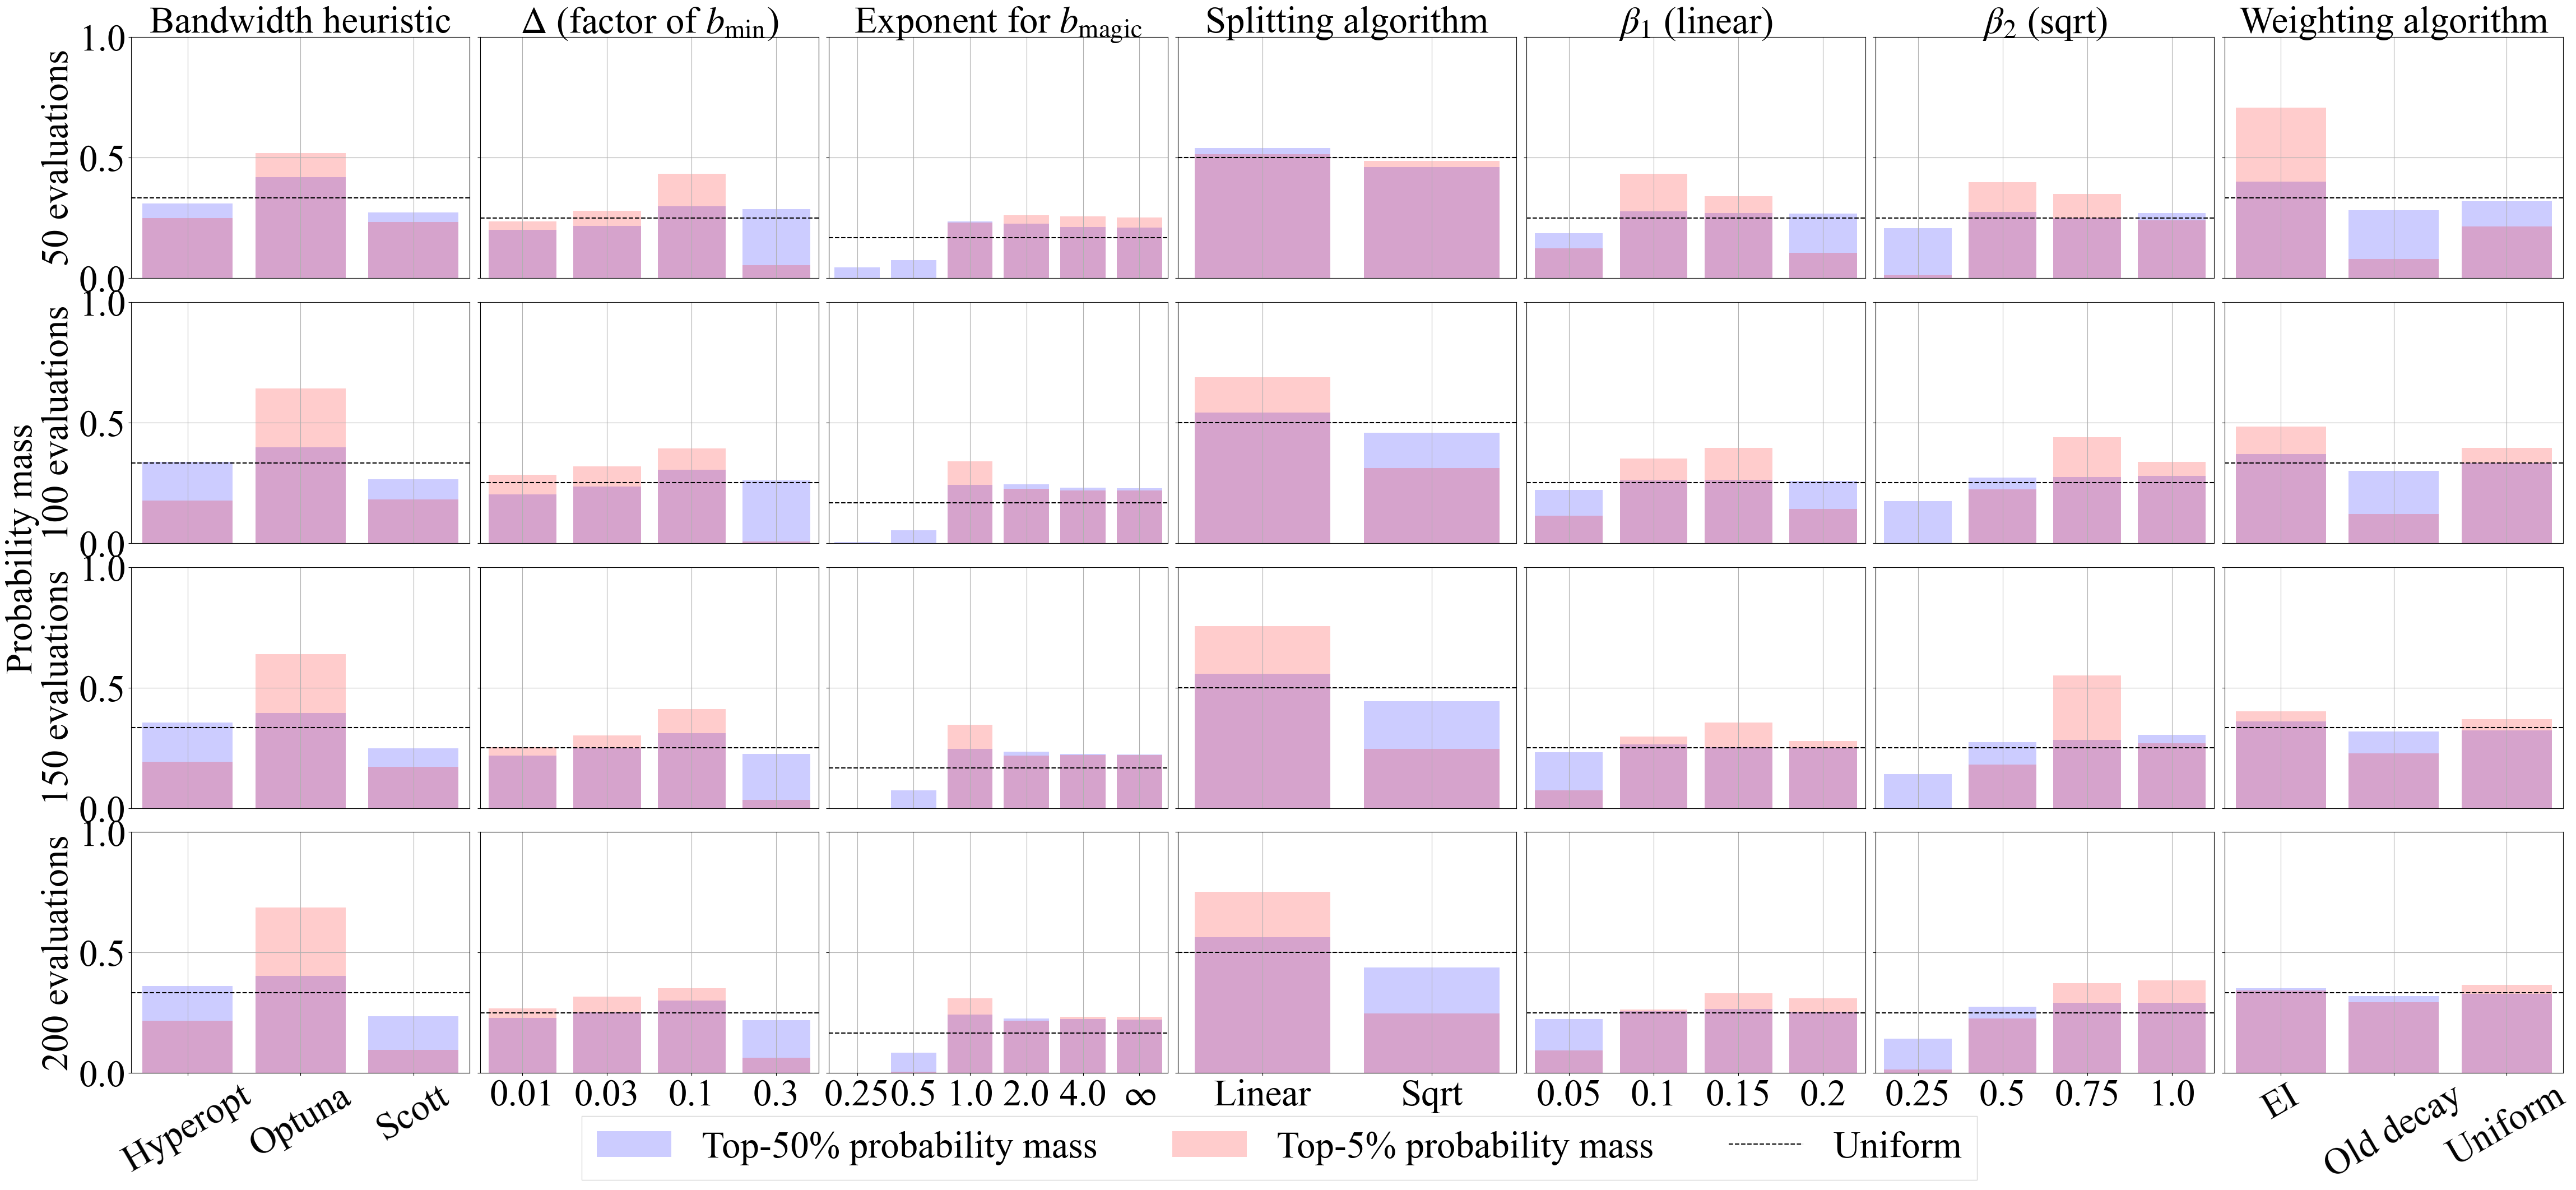

In [15]:
bench_names = ["parkinsons_telemonitoring", "protein_structure", "naval_propulsion", "slice_localization"]

fig, axes = plt.subplots(
    nrows=4,
    ncols=7,
    figsize=(56, 24),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.03,
        hspace=0.1,
    )
)

plot_pdf(bench_names, bbox_to_anchor=(0.3, -0.1))
plt.savefig(f"figs/hpolib-anova-bw.pdf", bbox_inches="tight")

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 5.82\% & 5.43\% & 5.68\% & 4.58\% \\
$\Delta$ (factor of $b_{\min}$) & 7.40\% & 17.52\% & 28.02\% & 33.17\% \\
Exponent for $b_{\mathrm{magic}}$ & 61.77\% & 58.50\% & 47.60\% & 44.72\% \\
Splitting algorithm & 0.32\% & 1.64\% & 2.93\% & 1.63\% \\
$\beta_1$ (linear) & 14.95\% & 6.21\% & 3.31\% & 3.01\% \\
$\beta_2$ (Sqrt) & 7.59\% & 8.77\% & 10.17\% & 10.64\% \\
Weighting algorithm & 2.15\% & 1.93\% & 2.30\% & 2.25\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Bandwidth heuristic & 7.53\% & 8.66\% & 26.17\% & 23.71\% \\
$\Delta$ (factor of $b_{\min}$) & 21.60\% & 7.27\% & 6.48\% & 7.55\% \\
Exponent for $b_{\mathrm{magic}}$ & 22.37\% & 6.91\% & 9.09\% & 7.32\% \\
Splitting algorithm & 2.36\% & 4.82\% & 8.21\% & 8.05\% \\
$\beta_1$ (linear) & 13.60\% & 17.50\% & 10.23\% & 7.99\% \\
$\beta_2$ (Sqrt) & 17.91\% & 33.75\% & 25.37\% & 29.95\% \\
Weighting algorithm & 14.63\% & 21.10\% & 14.46\% & 15.42\% \\
\end

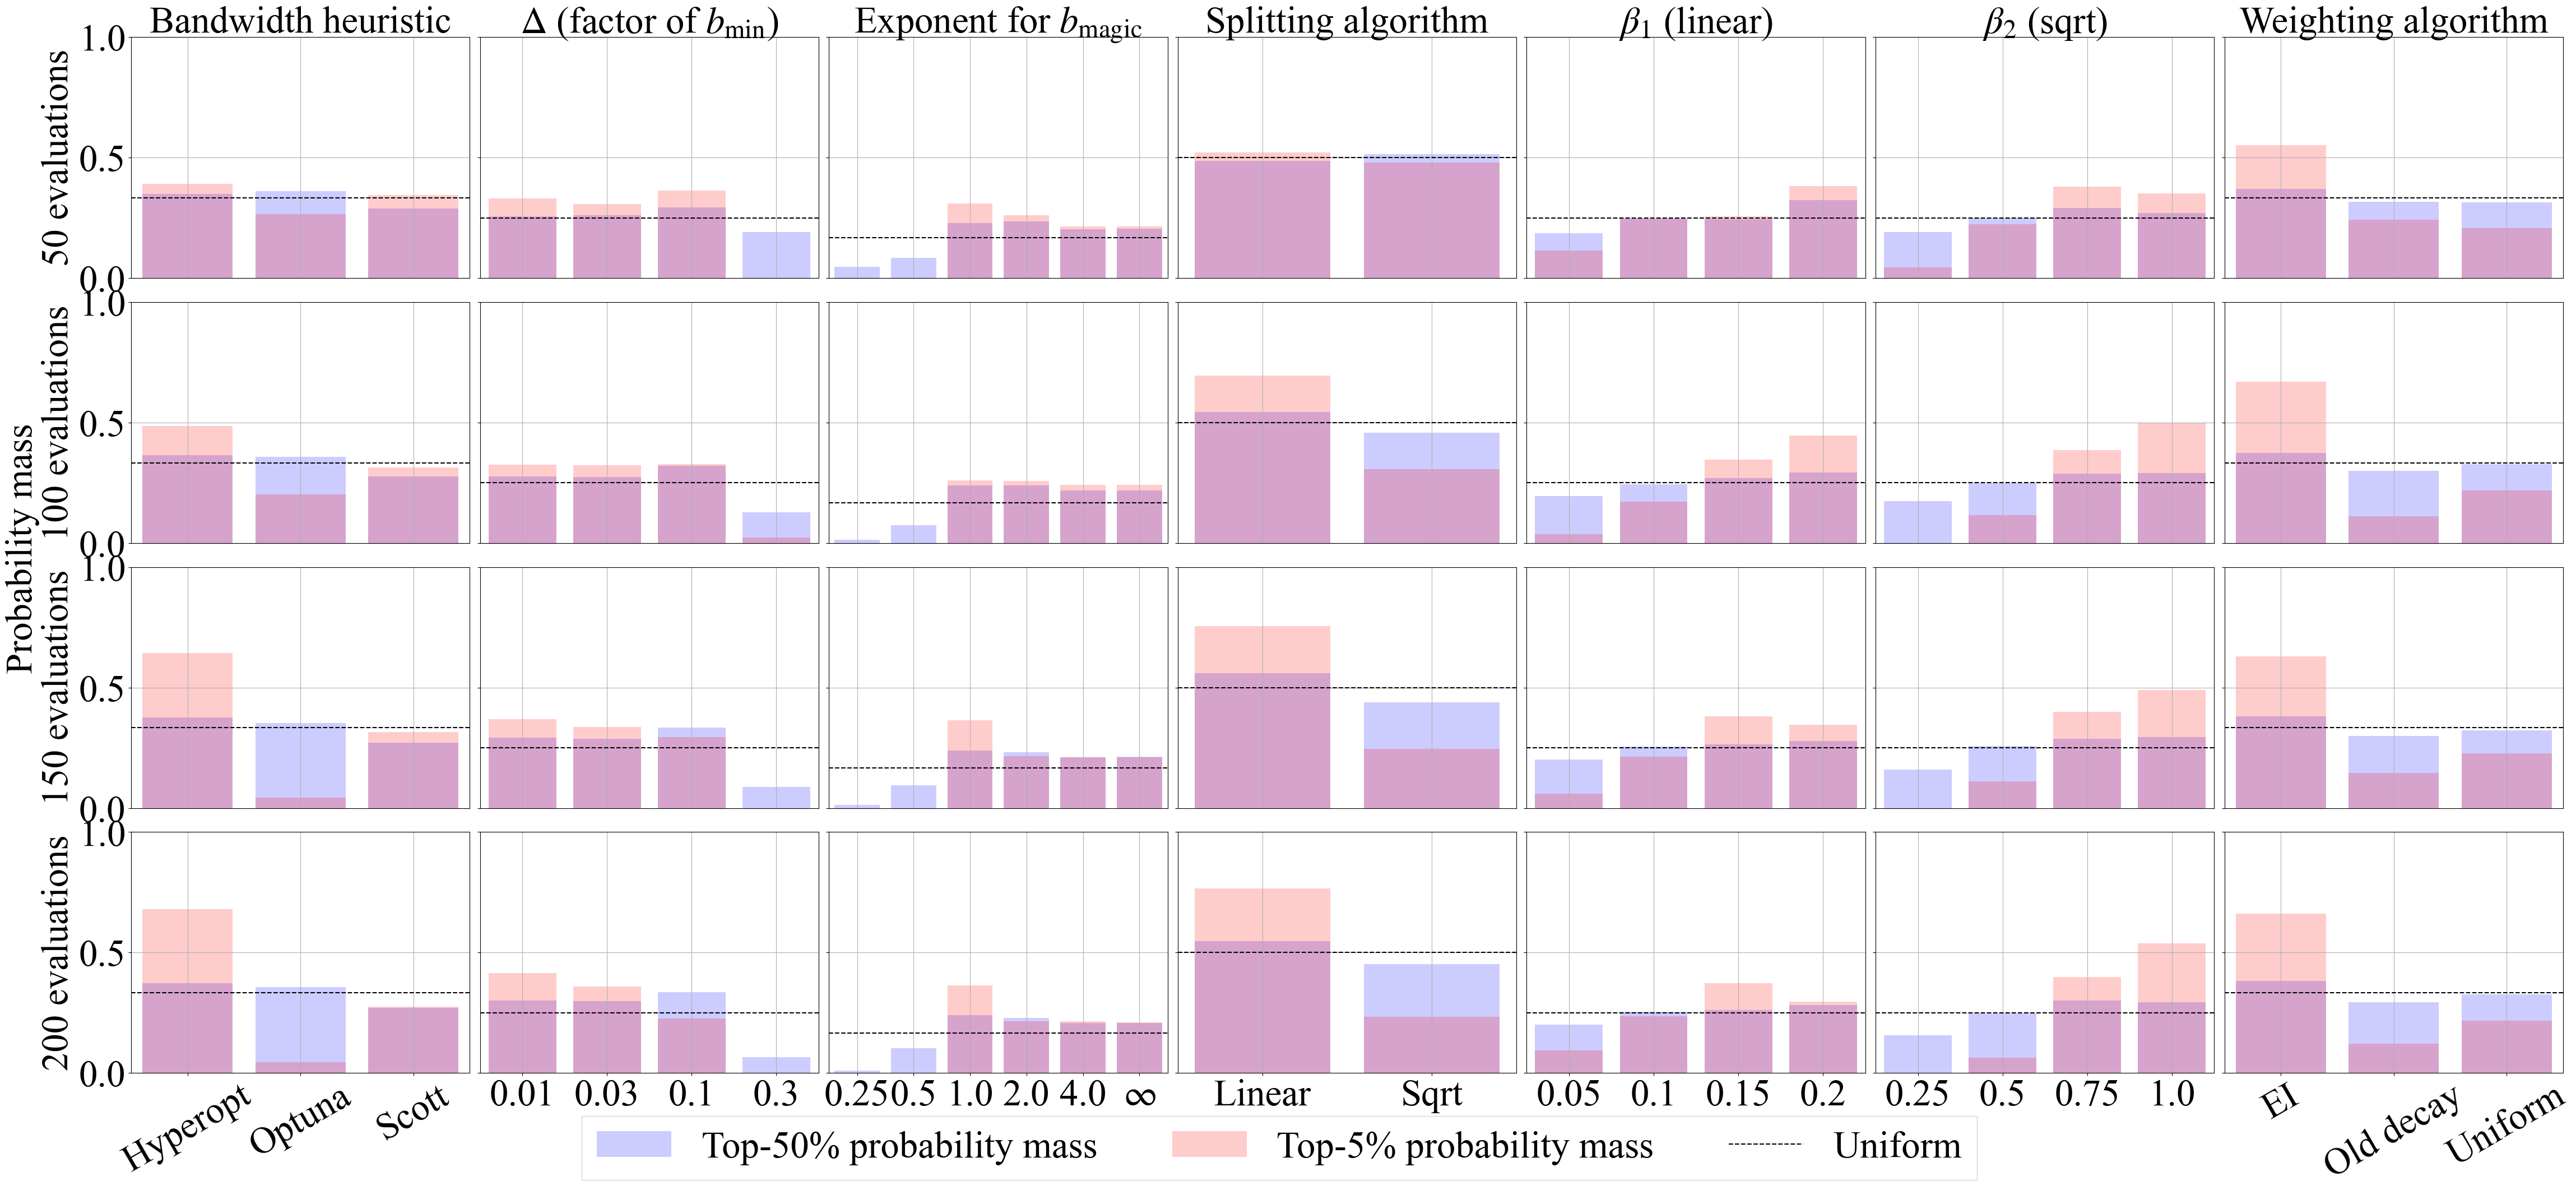

In [16]:
bench_names = ["cifar10", "fashion_mnist", "colorectal_histology"]

fig, axes = plt.subplots(
    nrows=4,
    ncols=7,
    figsize=(56, 24),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.03,
        hspace=0.1,
    )
)

plot_pdf(bench_names, bbox_to_anchor=(0.3, -0.1))
plt.savefig(f"figs/jahs-anova-bw.pdf", bbox_inches="tight")